# Análisis Exploratorio de Datos (EDA)


Este notebook está dedicado a realizar un análisis exploratorio de un dataset de imágenes dentales, que hemos alojado en la plataforma Roboflow. Puedes acceder al dataset desde el siguiente enlace:

- [Acceder al Dataset en Roboflow](https://app.roboflow.com/marco-joel-isidro-btxny/coronas-endodoncias-caries-impactados)

El propósito de este análisis es comprender mejor las características y distribuciones del dataset, lo cual nos permitirá identificar posibles patrones, desbalances de clases y otras propiedades importantes para el desarrollo de nuestros modelos de machine learning.

Para mantener el repositorio organizado y evitar subir grandes archivos, el dataset ha sido excluido del control de versiones mediante .gitignore. Sin embargo, el análisis realizado en este notebook corresponde directamente al dataset mencionado.

Este EDA nos proporcionará las siguientes métricas y visualizaciones clave:

- Distribución de las clases en el dataset.
- Número total de imágenes y anotaciones.
- Frecuencia de objetos por clase en cada imagen.
- Distribución del tamaño de los bounding boxes.
- Análisis del desbalance de clases y co-ocurrencia de objetos.

Estas métricas nos permitirán tomar decisiones fundamentadas para el preprocesamiento y optimización de los modelos.

----
## Datasets Original

### Descarga del dataset

In [60]:
# Bajo el dataset original dentro de la carpeta `/datasets/``
import os
from dotenv import load_dotenv
from roboflow import Roboflow

load_dotenv(dotenv_path=".env")
api_key = os.getenv('DS_ORIGINAL_API_KEY')

%cd ../datasets/
from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("dental-ct3nf").project("dentex-pg5h5")
version = project.version(1)
dataset = version.download("coco")
%cd ../notebooks/

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


/Users/diegosarina/Development/personal/diegosarina-ceia_publico/vpc-II/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DENTEX-1 in coco:: 100%|██████████| 762/762 [00:00<00:00, 2055.98it/s]

/Users/diegosarina/Development/personal/diegosarina-ceia_publico/vpc-II/notebooks


### Carga del dataset y analisis

In [61]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_coco_json(json_paths):
    """
    Carga múltiples archivos JSON en formato COCO y combina los DataFrames de imágenes, anotaciones y categorías.
    
    Args:
        json_paths (list): Lista de rutas a los archivos JSON (train, test, valid).
        
    Returns:
        tuple: DataFrames combinados de imágenes, anotaciones y categorías.
    """
    df_images_list = []
    df_annotations_list = []
    df_categories = None
    
    for json_path in json_paths:
        with open(json_path, 'r') as f:
            coco_data = json.load(f)
        
        # Crear DataFrames
        df_images = pd.DataFrame(coco_data['images'])
        df_annotations = pd.DataFrame(coco_data['annotations'])
        df_categories = pd.DataFrame(coco_data['categories'])
        
        # Mapeo de categorías (solo si no se ha hecho antes)
        if df_categories is not None and 'category_name' not in df_annotations.columns:
            category_mapping = {row['id']: row['name'] for _, row in df_categories.iterrows()}
            df_annotations['category_name'] = df_annotations['category_id'].map(category_mapping)
        
        # Agregar a las listas
        df_images_list.append(df_images)
        df_annotations_list.append(df_annotations)
    
    # Combinar todos los DataFrames
    df_images_combined = pd.concat(df_images_list, ignore_index=True)
    df_annotations_combined = pd.concat(df_annotations_list, ignore_index=True)
    
    return df_images_combined, df_annotations_combined, df_categories

# Lista de rutas de los JSONs de train, test y valid
json_paths = [
    '../datasets/DENTEX-1/train/_annotations.coco.json',
    '../datasets/DENTEX-1/valid/_annotations.coco.json',
    '../datasets/DENTEX-1/test/_annotations.coco.json'
]

# Cargar y combinar los datasets
df_images, df_annotations, categories = load_coco_json(json_paths)

In [62]:
print(f"\n--- Dataset info ---")

# Total de anotaciones
total_annotations = len(df_annotations)
print(f"Total de anotaciones: {total_annotations}")

# Total de imágenes
total_images = len(df_images)
print(f"Total de imágenes: {total_images}")

# Distribución de las clases
class_distribution = df_annotations['category_name'].value_counts()
print(f"\nDistribución de clases:\n{class_distribution}")


--- Dataset info ---
Total de anotaciones: 3708
Total de imágenes: 754

Distribución de clases:
category_name
Caries               2290
Impacted              643
Deep Caries           608
Periapical Lesion     167
Name: count, dtype: int64


##### Distribución de las Clases en el Dataset

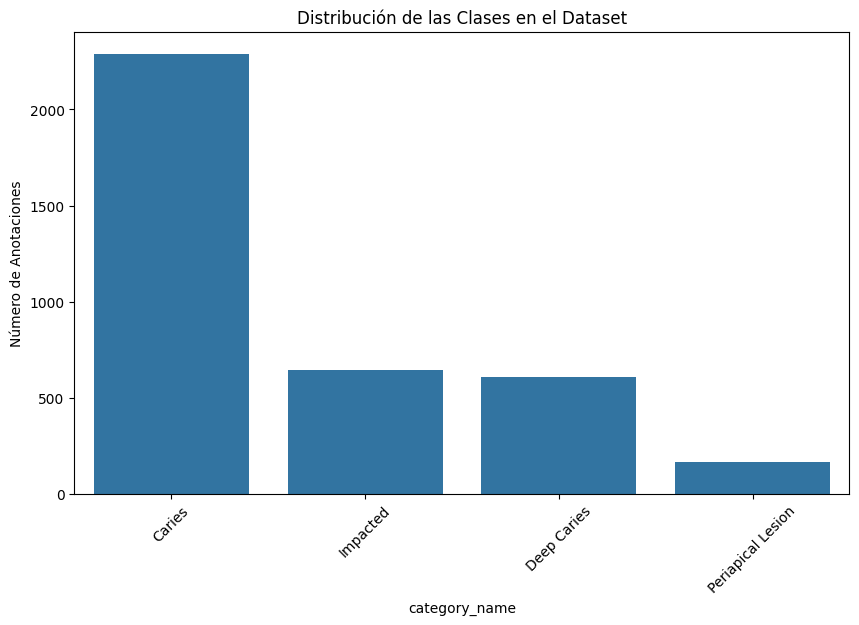

In [63]:
# Visualización de la distribución de clases
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title(f'Distribución de las Clases en el Dataset')
plt.ylabel('Número de Anotaciones')
plt.xticks(rotation=45)
plt.show()


A partir de la gráfica anterior, vemos que:

- El dataset muestra un desbalance significativo entre las clases. La clase "Caries" es predominante, con más del doble de anotaciones que las otras clases.

- Este desbalance podría afectar el rendimiento del modelo, favoreciendo la detección de caries sobre otras condiciones.

##### Distribución de Anotaciones por Imagen en el datasets

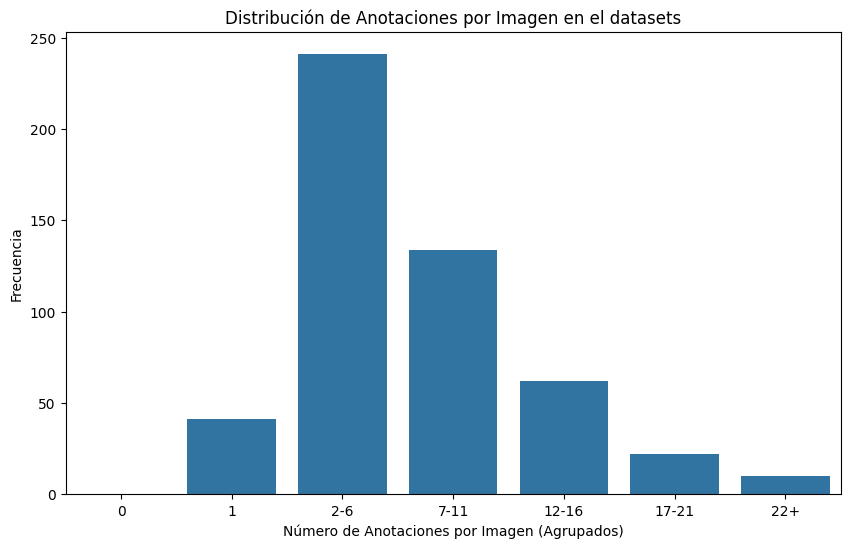

In [64]:
annotations_per_image = df_annotations.groupby('image_id').size()

bins = [0, 1, 2, 7, 12, 17, 22, float('inf')]  # Se agrega un bin adicional para 22+
labels = ['0', '1', '2-6', '7-11', '12-16', '17-21', '22+']

# Cortar los datos en los bins personalizados
annotations_per_image_binned = pd.cut(annotations_per_image, bins=bins, labels=labels, right=False)
# Contar la frecuencia de cada grupo
count_per_bin = annotations_per_image_binned.value_counts().sort_index()

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=count_per_bin.index, y=count_per_bin.values)

# Añadir títulos y etiquetas
plt.title(f'Distribución de Anotaciones por Imagen en el datasets')
plt.xlabel('Número de Anotaciones por Imagen (Agrupados)')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()



Algunas observaciones aquí son:

- La mayoría de las imágenes contienen entre 2 y 11 anotaciones, con un pico en el rango de 2-6 anotaciones por imagen.

- Esto sugiere que muchas radiografías panorámicas presentan múltiples condiciones dentales simultáneamente.

##### Frecuencia de Objetos por Clase en Cada Imagen

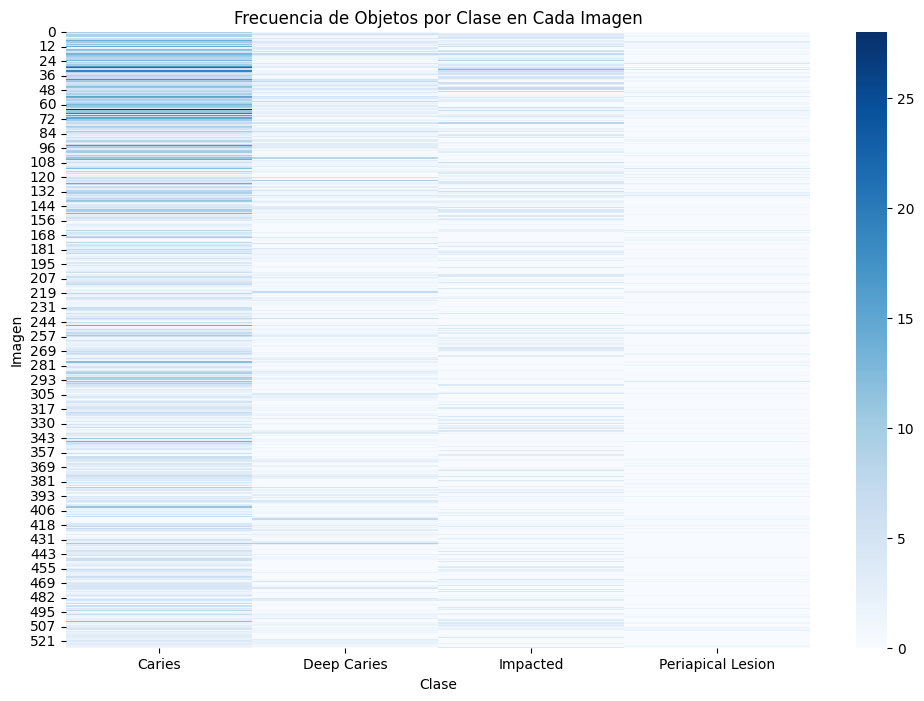

In [65]:
# Crear un DataFrame que asocie imágenes con clases a partir de las anotaciones
class_per_image = pd.DataFrame({
    'image_id': df_annotations['image_id'],
    'class': df_annotations['category_name']
})

# Contar la cantidad de objetos de cada clase por imagen
class_distribution = class_per_image.groupby(['image_id', 'class']).size().unstack(fill_value=0)

# Visualización: Mapa de calor de la frecuencia de objetos por clase en cada imagen
plt.figure(figsize=(12, 8))
sns.heatmap(class_distribution, cmap='Blues', cbar=True)
plt.title('Frecuencia de Objetos por Clase en Cada Imagen')
plt.xlabel('Clase')
plt.ylabel('Imagen')
plt.show()

##### Tamaño Promedio de Bounding Boxes por Clase

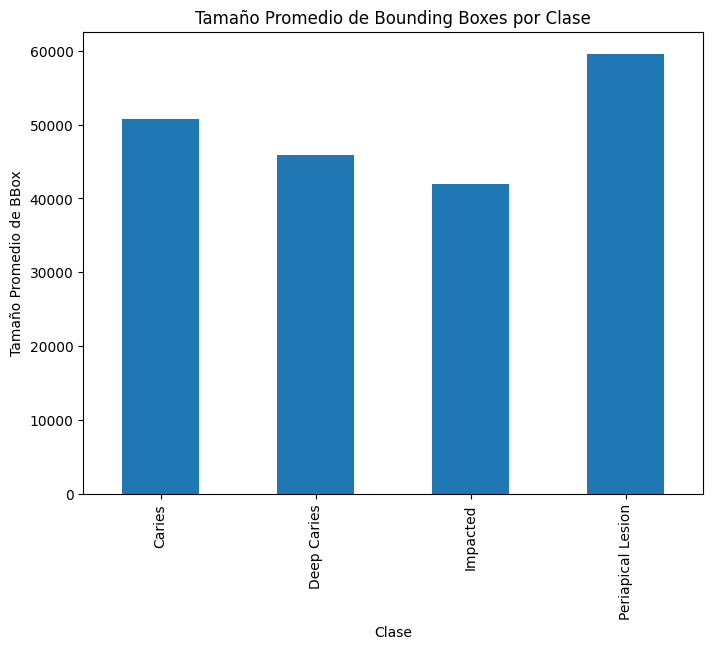

In [66]:
# Tamaño Promedio de los Bounding Boxes por Clase
# variabilidad de los tamaños de los objetos que el modelo necesita detectar.
df_annotations['bbox_area'] = df_annotations['bbox'].apply(lambda x: x[2] * x[3])
bbox_avg_per_class = df_annotations.groupby('category_name')['bbox_area'].mean()

plt.figure(figsize=(8, 6))
bbox_avg_per_class.plot(kind='bar')
plt.title('Tamaño Promedio de Bounding Boxes por Clase')
plt.xlabel('Clase')
plt.ylabel('Tamaño Promedio de BBox')
plt.show()

Tamaño de los bounding boxes:

- Hay una variación considerable en el tamaño promedio de los bounding boxes entre las diferentes clases.

- Las lesiones periapicales tienen los bounding boxes más grandes en promedio, lo que podría indicar que estas condiciones abarcan áreas más extensas en las radiografías.

##### Distribución de Resoluciones de las Imágenes

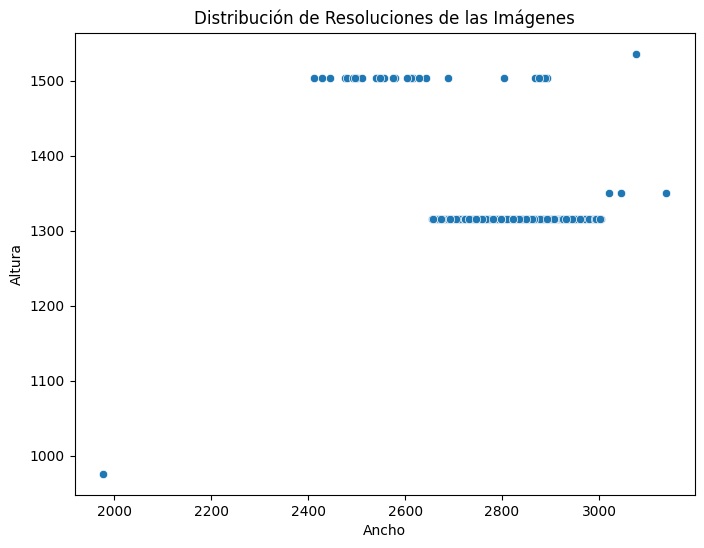

In [67]:
# 4. Distribución de Resoluciones de las Imágenes
image_resolutions = df_images[['height', 'width']].drop_duplicates()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='width', y='height', data=image_resolutions)
plt.title('Distribución de Resoluciones de las Imágenes')
plt.xlabel('Ancho')
plt.ylabel('Altura')
plt.show()

##### Distribución Geográfica de las Anotaciones por Clase

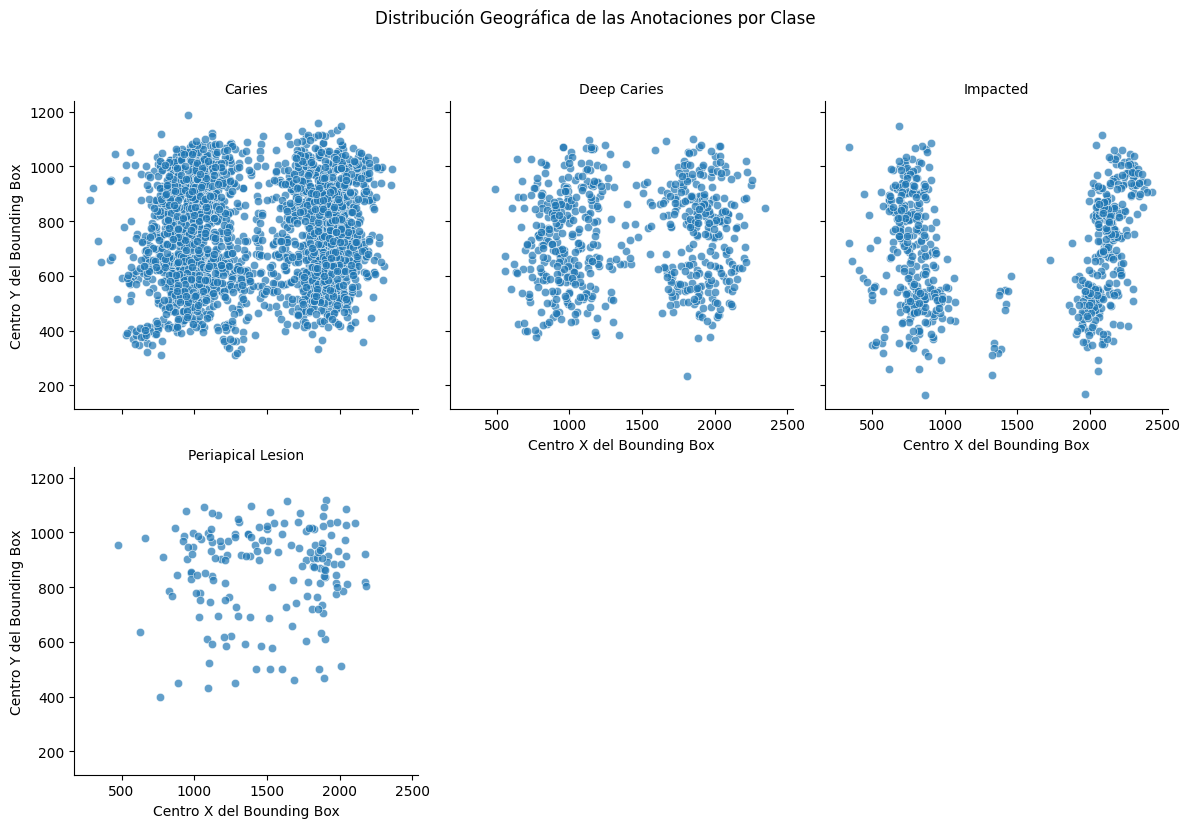

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Añadir las columnas del centro de los bounding boxes
df_annotations['x_center'] = df_annotations['bbox'].apply(lambda x: x[0] + x[2] / 2)
df_annotations['y_center'] = df_annotations['bbox'].apply(lambda x: x[1] + x[3] / 2)

# Crear un FacetGrid para visualizar la distribución por clases
g = sns.FacetGrid(df_annotations, col='category_name', col_wrap=3, height=4)
g.map(sns.scatterplot, 'x_center', 'y_center', alpha=0.7)

# Ajustes adicionales para los gráficos
g.set_titles('{col_name}')
g.set_axis_labels('Centro X del Bounding Box', 'Centro Y del Bounding Box')
g.fig.suptitle('Distribución Geográfica de las Anotaciones por Clase', y=1.03)

plt.tight_layout()
plt.show()


Distribución espacial:

- Las anotaciones para cada clase muestran patrones de distribución espacial distintos en las imágenes.

- Esto refleja la anatomía dental y la naturaleza de cada condición (por ejemplo, los dientes impactados tienden a agruparse en ciertas áreas).

##### Relación Ancho-Altura (Aspect Ratio) de los Bounding Boxes por Clase



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



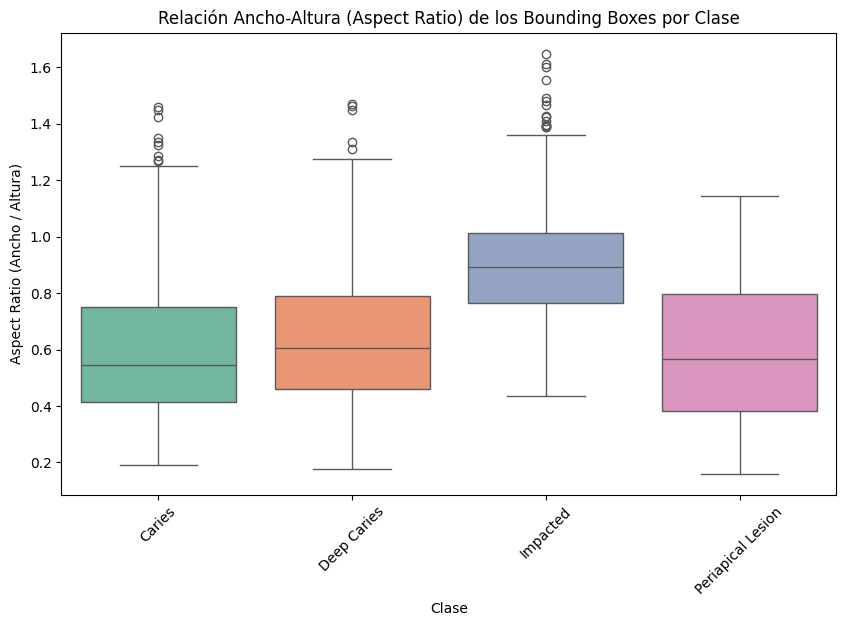

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular el Aspect Ratio (Ancho / Altura)
df_annotations['aspect_ratio'] = df_annotations['bbox'].apply(lambda x: x[2] / x[3])

# Crear un gráfico de distribución del aspect ratio por clase
plt.figure(figsize=(10, 6))
sns.boxplot(x='category_name', y='aspect_ratio', data=df_annotations, palette='Set2')
plt.title('Relación Ancho-Altura (Aspect Ratio) de los Bounding Boxes por Clase')
plt.xlabel('Clase')
plt.ylabel('Aspect Ratio (Ancho / Altura)')
plt.xticks(rotation=45)
plt.show()


----
## Datasets Modificado

### Descarga del dataset

In [40]:
# Bajo el dataset original dentro de la carpeta `/datasets/``
import os
from dotenv import load_dotenv
from roboflow import Roboflow

load_dotenv(dotenv_path=".env")
api_key = os.getenv('DS_MODIFICADO_API_KEY')

%cd ../datasets/
rf = Roboflow(api_key=api_key)
project = rf.workspace("marco-joel-isidro-btxny").project("coronas-endodoncias-caries-impactados")
version = project.version(3)
dataset = version.download("coco")

%cd ../notebooks/

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


/Users/diegosarina/Development/personal/diegosarina-ceia_publico/vpc-II/datasets
loading Roboflow workspace...
loading Roboflow project...
/Users/diegosarina/Development/personal/diegosarina-ceia_publico/vpc-II/notebooks


### Carga del dataset y analisis

In [41]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_coco_json(json_paths):
    """
    Carga múltiples archivos JSON en formato COCO y combina los DataFrames de imágenes, anotaciones y categorías.
    
    Args:
        json_paths (list): Lista de rutas a los archivos JSON (train, test, valid).
        
    Returns:
        tuple: DataFrames combinados de imágenes, anotaciones y categorías.
    """
    df_images_list = []
    df_annotations_list = []
    df_categories = None
    
    for json_path in json_paths:
        with open(json_path, 'r') as f:
            coco_data = json.load(f)
        
        # Crear DataFrames
        df_images = pd.DataFrame(coco_data['images'])
        df_annotations = pd.DataFrame(coco_data['annotations'])
        df_categories = pd.DataFrame(coco_data['categories'])
        
        # Mapeo de categorías (solo si no se ha hecho antes)
        if df_categories is not None and 'category_name' not in df_annotations.columns:
            category_mapping = {row['id']: row['name'] for _, row in df_categories.iterrows()}
            df_annotations['category_name'] = df_annotations['category_id'].map(category_mapping)
        
        # Agregar a las listas
        df_images_list.append(df_images)
        df_annotations_list.append(df_annotations)
    
    # Combinar todos los DataFrames
    df_images_combined = pd.concat(df_images_list, ignore_index=True)
    df_annotations_combined = pd.concat(df_annotations_list, ignore_index=True)
    
    return df_images_combined, df_annotations_combined, df_categories

# Lista de rutas de los JSONs de train, test y valid
json_paths = [
    '../datasets/Coronas,-Endodoncias,-Caries,-impactados-3/train/_annotations.coco.json',
    '../datasets/Coronas,-Endodoncias,-Caries,-impactados-3/valid/_annotations.coco.json',
    '../datasets/Coronas,-Endodoncias,-Caries,-impactados-3/test/_annotations.coco.json'
]

# Cargar y combinar los datasets
df_images, df_annotations, categories = load_coco_json(json_paths)

In [42]:
print(f"\n--- Dataset info ---")

# Total de anotaciones
total_annotations = len(df_annotations)
print(f"Total de anotaciones: {total_annotations}")

# Total de imágenes
total_images = len(df_images)
print(f"Total de imágenes: {total_images}")

# Distribución de las clases
class_distribution = df_annotations['category_name'].value_counts()
print(f"\nDistribución de clases:\n{class_distribution}")


--- Dataset info ---
Total de anotaciones: 4452
Total de imágenes: 805

Distribución de clases:
category_name
corona              1487
caries              1411
endodoncia          1043
diente impactado     477
implante              34
Name: count, dtype: int64


##### Distribución de las Clases en el Dataset

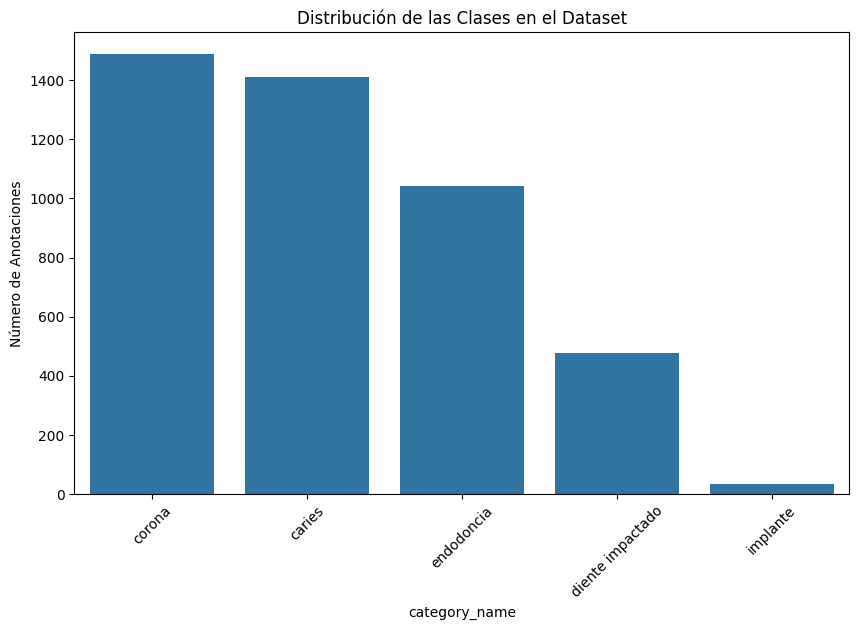

In [43]:
# Visualización de la distribución de clases
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title(f'Distribución de las Clases en el Dataset')
plt.ylabel('Número de Anotaciones')
plt.xticks(rotation=45)
plt.show()

A raíz del gráfico anterior, podemos ver que:

- Existe un desbalance moderado entre las clases.

- Las categorías "corona" y "caries" son dominantes, representando más del 65% de todas las anotaciones.

- La clase "implante" es significativamente minoritaria.

##### Distribución de Anotaciones por Imagen en el datasets

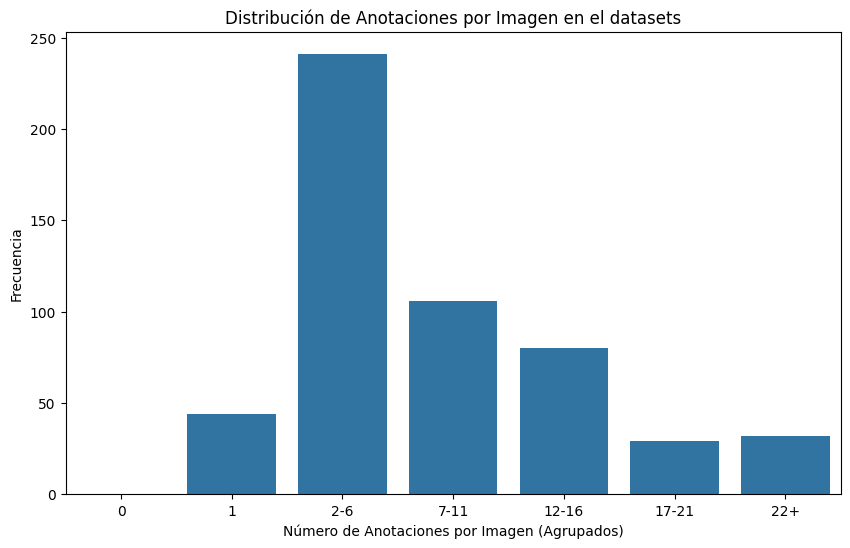

In [44]:
annotations_per_image = df_annotations.groupby('image_id').size()

bins = [0, 1, 2, 7, 12, 17, 22, float('inf')]  # Se agrega un bin adicional para 22+
labels = ['0', '1', '2-6', '7-11', '12-16', '17-21', '22+']

# Cortar los datos en los bins personalizados
annotations_per_image_binned = pd.cut(annotations_per_image, bins=bins, labels=labels, right=False)
# Contar la frecuencia de cada grupo
count_per_bin = annotations_per_image_binned.value_counts().sort_index()

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=count_per_bin.index, y=count_per_bin.values)

# Añadir títulos y etiquetas
plt.title(f'Distribución de Anotaciones por Imagen en el datasets')
plt.xlabel('Número de Anotaciones por Imagen (Agrupados)')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()



##### Frecuencia de Objetos por Clase en Cada Imagen

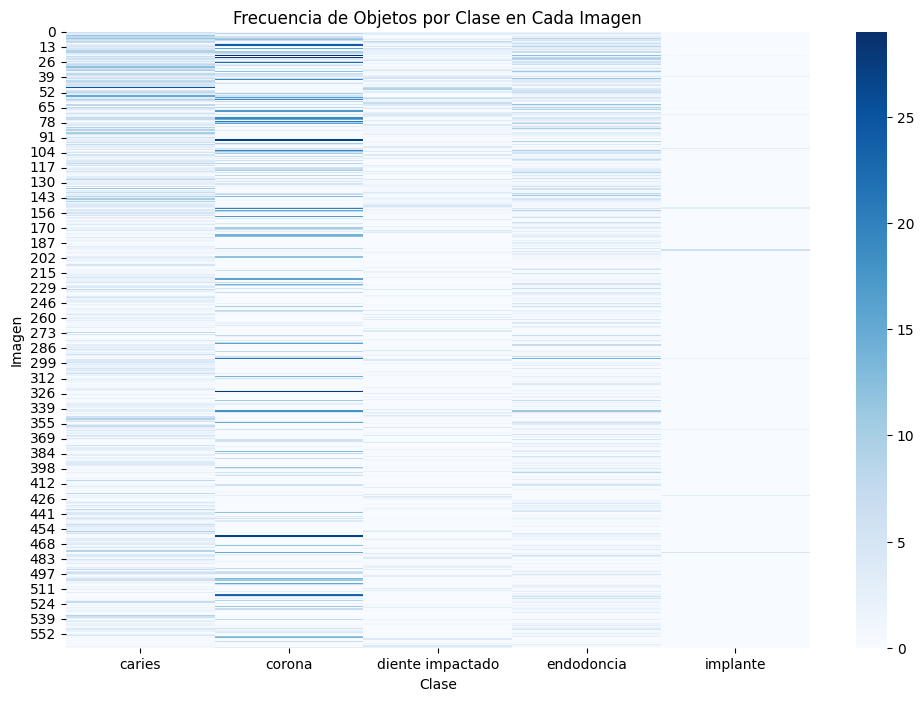

In [45]:
# Crear un DataFrame que asocie imágenes con clases a partir de las anotaciones
class_per_image = pd.DataFrame({
    'image_id': df_annotations['image_id'],
    'class': df_annotations['category_name']
})

# Contar la cantidad de objetos de cada clase por imagen
class_distribution = class_per_image.groupby(['image_id', 'class']).size().unstack(fill_value=0)

# Visualización: Mapa de calor de la frecuencia de objetos por clase en cada imagen
plt.figure(figsize=(12, 8))
sns.heatmap(class_distribution, cmap='Blues', cbar=True)
plt.title('Frecuencia de Objetos por Clase en Cada Imagen')
plt.xlabel('Clase')
plt.ylabel('Imagen')
plt.show()

##### Tamaño Promedio de Bounding Boxes por Clase

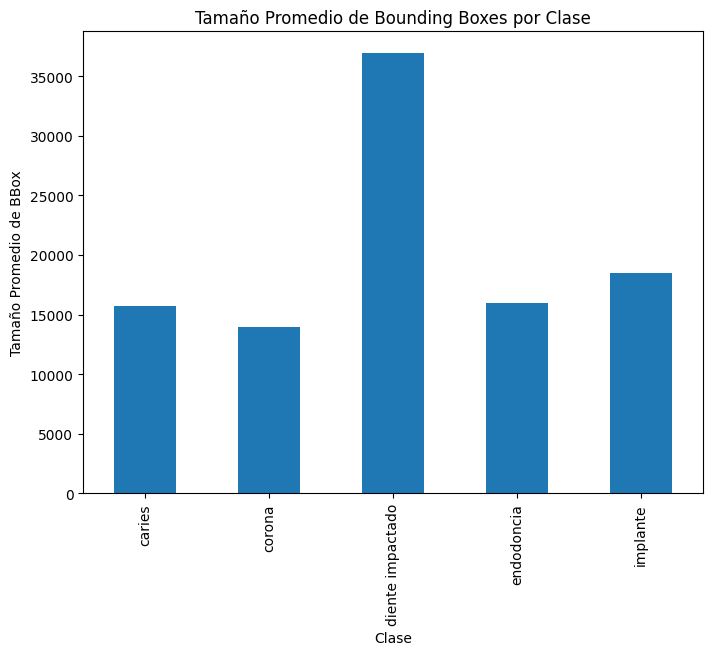

In [46]:
# Tamaño Promedio de los Bounding Boxes por Clase
# variabilidad de los tamaños de los objetos que el modelo necesita detectar.
df_annotations['bbox_area'] = df_annotations['bbox'].apply(lambda x: x[2] * x[3])
bbox_avg_per_class = df_annotations.groupby('category_name')['bbox_area'].mean()

plt.figure(figsize=(8, 6))
bbox_avg_per_class.plot(kind='bar')
plt.title('Tamaño Promedio de Bounding Boxes por Clase')
plt.xlabel('Clase')
plt.ylabel('Tamaño Promedio de BBox')
plt.show()

- Dientes impactados tienen los bounding boxes más grandes.

- Implantes y endodoncias muestran tamaños similares, ligeramente mayores que coronas y caries.

- Caries tienen los bounding boxes más pequeños en promedio.

##### Distribución de Resoluciones de las Imágenes

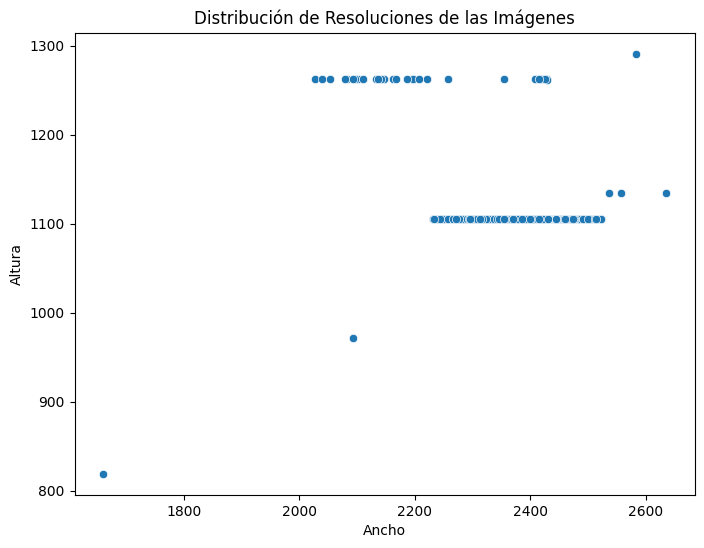

In [47]:
# 4. Distribución de Resoluciones de las Imágenes
image_resolutions = df_images[['height', 'width']].drop_duplicates()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='width', y='height', data=image_resolutions)
plt.title('Distribución de Resoluciones de las Imágenes')
plt.xlabel('Ancho')
plt.ylabel('Altura')
plt.show()

##### Distribución Geográfica de las Anotaciones por Clase

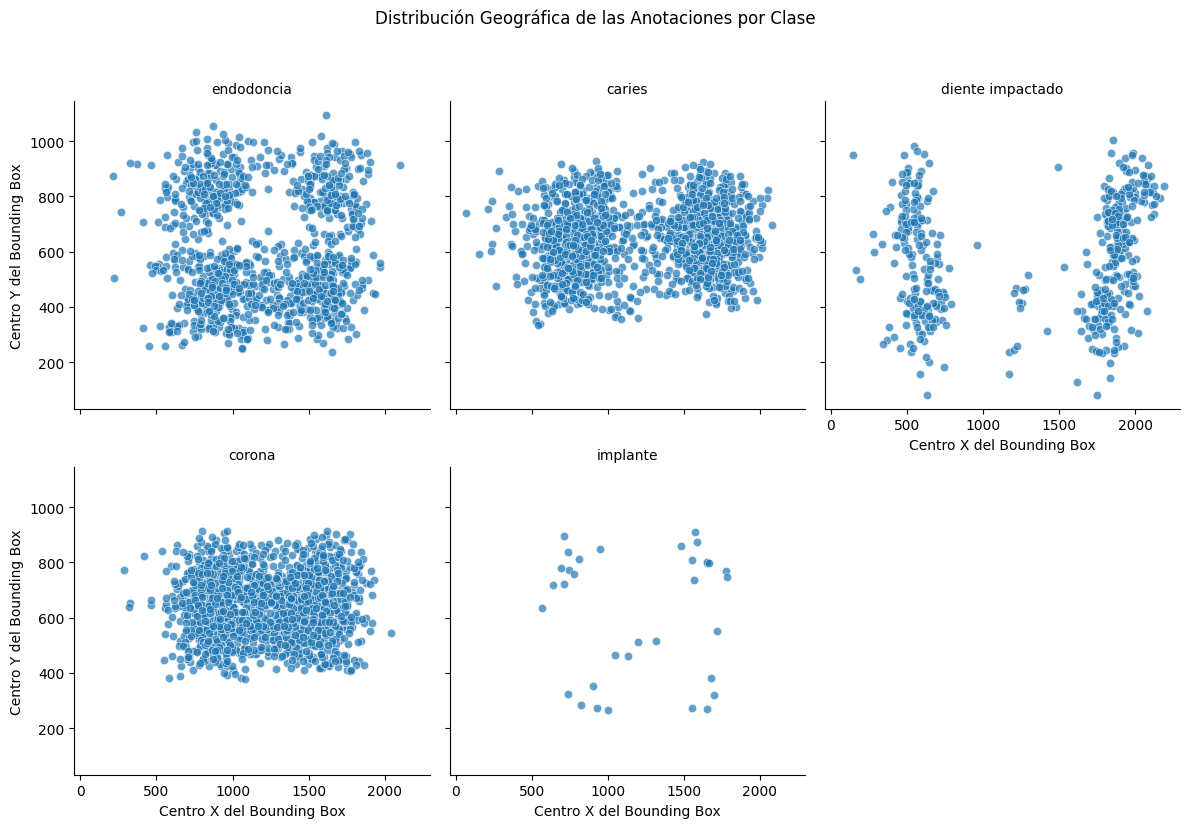

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Añadir las columnas del centro de los bounding boxes
df_annotations['x_center'] = df_annotations['bbox'].apply(lambda x: x[0] + x[2] / 2)
df_annotations['y_center'] = df_annotations['bbox'].apply(lambda x: x[1] + x[3] / 2)

# Crear un FacetGrid para visualizar la distribución por clases
g = sns.FacetGrid(df_annotations, col='category_name', col_wrap=3, height=4)
g.map(sns.scatterplot, 'x_center', 'y_center', alpha=0.7)

# Ajustes adicionales para los gráficos
g.set_titles('{col_name}')
g.set_axis_labels('Centro X del Bounding Box', 'Centro Y del Bounding Box')
g.fig.suptitle('Distribución Geográfica de las Anotaciones por Clase', y=1.03)

plt.tight_layout()
plt.show()


- Endodoncia: Distribuida ampliamente, con mayor concentración en las áreas centrales.

- Caries: Dispersas por toda la imagen, con ligera concentración en las áreas centrales.

- Diente impactado: Concentrados principalmente en las regiones inferiores de la imagen.

- Corona: Distribución amplia y uniforme en toda la imagen.

- Implante: Escasos y localizados en áreas específicas.

- La posición de las anotaciones podría ser un factor informativo para algunas clases (ej. dientes impactados).

##### Relación Ancho-Altura (Aspect Ratio) de los Bounding Boxes por Clase



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



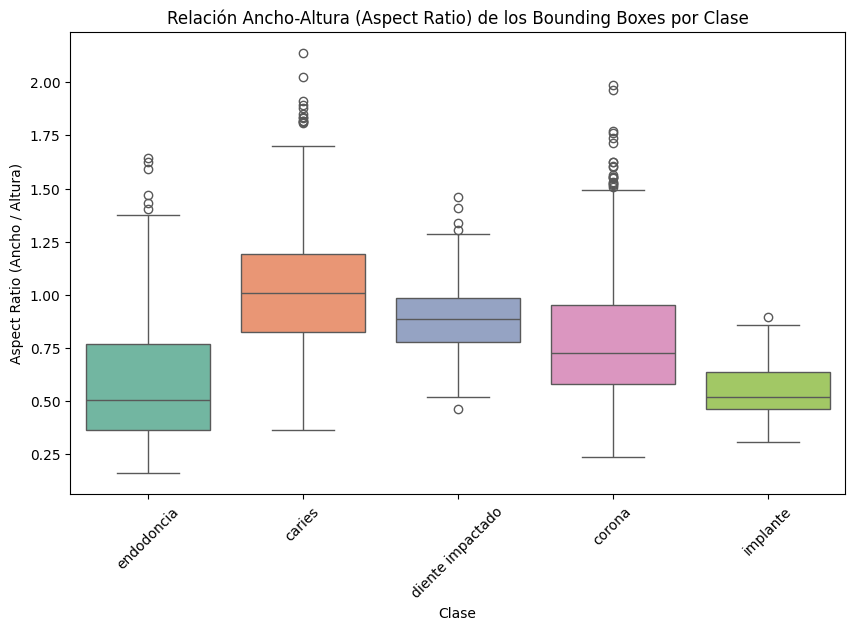

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular el Aspect Ratio (Ancho / Altura)
df_annotations['aspect_ratio'] = df_annotations['bbox'].apply(lambda x: x[2] / x[3])

# Crear un gráfico de distribución del aspect ratio por clase
plt.figure(figsize=(10, 6))
sns.boxplot(x='category_name', y='aspect_ratio', data=df_annotations, palette='Set2')
plt.title('Relación Ancho-Altura (Aspect Ratio) de los Bounding Boxes por Clase')
plt.xlabel('Clase')
plt.ylabel('Aspect Ratio (Ancho / Altura)')
plt.xticks(rotation=45)
plt.show()


- Endodoncia: Tienden a ser más altos que anchos (aspect ratio bajo).
- Caries: Muestran la mayor variabilidad en su relación de aspecto.
- Diente impactado: Aspect ratio generalmente cercano a 1, con moderada variabilidad.
- Corona: Variabilidad moderada, tendiendo a ser ligeramente más anchas que altas.
- Implante: Relación de aspecto más consistente y cercana a 1.

----
## Datasets Modificado con data augmentation

### Descarga del dataset

In [50]:
# Bajo el dataset original dentro de la carpeta `/datasets/``
import os
from dotenv import load_dotenv
from roboflow import Roboflow

load_dotenv(dotenv_path=".env")
api_key = os.getenv('DS_MODIFICADO_API_KEY')

%cd ../datasets/
rf = Roboflow(api_key=api_key)
project = rf.workspace("marco-joel-isidro-btxny").project("coronas-endodoncias-caries-impactados")
version = project.version(2)
dataset = version.download("coco")

%cd ../notebooks/

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


/Users/diegosarina/Development/personal/diegosarina-ceia_publico/vpc-II/datasets
loading Roboflow workspace...
loading Roboflow project...
/Users/diegosarina/Development/personal/diegosarina-ceia_publico/vpc-II/notebooks


### Carga del dataset y analisis

In [51]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def load_coco_json(json_paths):
    """
    Carga múltiples archivos JSON en formato COCO y combina los DataFrames de imágenes, anotaciones y categorías.
    
    Args:
        json_paths (list): Lista de rutas a los archivos JSON (train, test, valid).
        
    Returns:
        tuple: DataFrames combinados de imágenes, anotaciones y categorías.
    """
    df_images_list = []
    df_annotations_list = []
    df_categories = None
    
    for json_path in json_paths:
        with open(json_path, 'r') as f:
            coco_data = json.load(f)
        
        # Crear DataFrames
        df_images = pd.DataFrame(coco_data['images'])
        df_annotations = pd.DataFrame(coco_data['annotations'])
        df_categories = pd.DataFrame(coco_data['categories'])
        
        # Mapeo de categorías (solo si no se ha hecho antes)
        if df_categories is not None and 'category_name' not in df_annotations.columns:
            category_mapping = {row['id']: row['name'] for _, row in df_categories.iterrows()}
            df_annotations['category_name'] = df_annotations['category_id'].map(category_mapping)
        
        # Agregar a las listas
        df_images_list.append(df_images)
        df_annotations_list.append(df_annotations)
    
    # Combinar todos los DataFrames
    df_images_combined = pd.concat(df_images_list, ignore_index=True)
    df_annotations_combined = pd.concat(df_annotations_list, ignore_index=True)
    
    return df_images_combined, df_annotations_combined, df_categories

# Lista de rutas de los JSONs de train, test y valid
json_paths = [
    '../datasets/Coronas,-Endodoncias,-Caries,-impactados-2/train/_annotations.coco.json',
    '../datasets/Coronas,-Endodoncias,-Caries,-impactados-2/valid/_annotations.coco.json',
    '../datasets/Coronas,-Endodoncias,-Caries,-impactados-2/test/_annotations.coco.json'
]

# Cargar y combinar los datasets
df_images, df_annotations, categories = load_coco_json(json_paths)

In [52]:
print(f"\n--- Dataset info ---")

# Total de anotaciones
total_annotations = len(df_annotations)
print(f"Total de anotaciones: {total_annotations}")

# Total de imágenes
total_images = len(df_images)
print(f"Total de imágenes: {total_images}")

# Distribución de las clases
class_distribution = df_annotations['category_name'].value_counts()
print(f"\nDistribución de clases:\n{class_distribution}")


--- Dataset info ---
Total de anotaciones: 10732
Total de imágenes: 1933

Distribución de clases:
category_name
corona              3659
caries              3369
endodoncia          2517
diente impactado    1113
implante              74
Name: count, dtype: int64


#### Distribución de las Clases en el Dataset

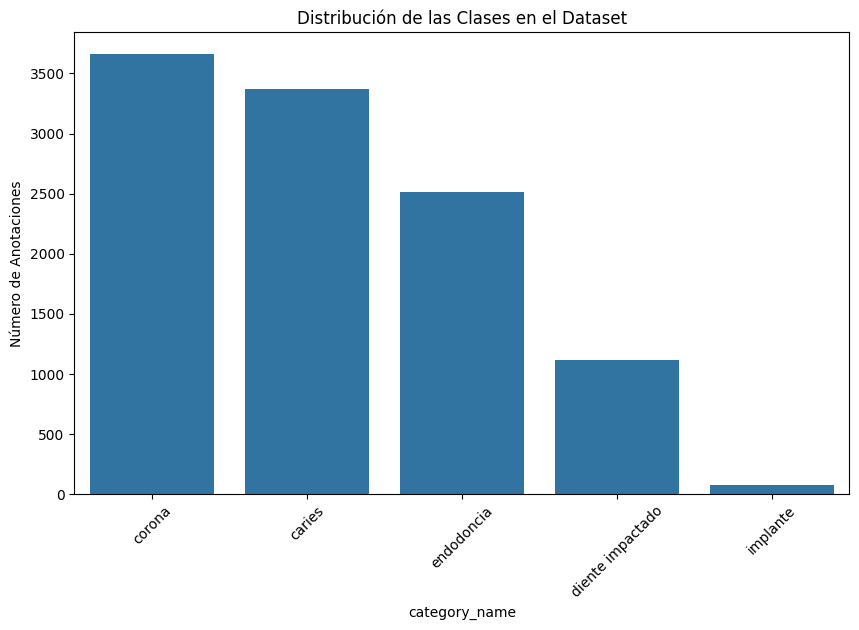

In [53]:
# Visualización de la distribución de clases
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title(f'Distribución de las Clases en el Dataset')
plt.ylabel('Número de Anotaciones')
plt.xticks(rotation=45)
plt.show()

##### Distribución de Anotaciones por Imagen en el datasets

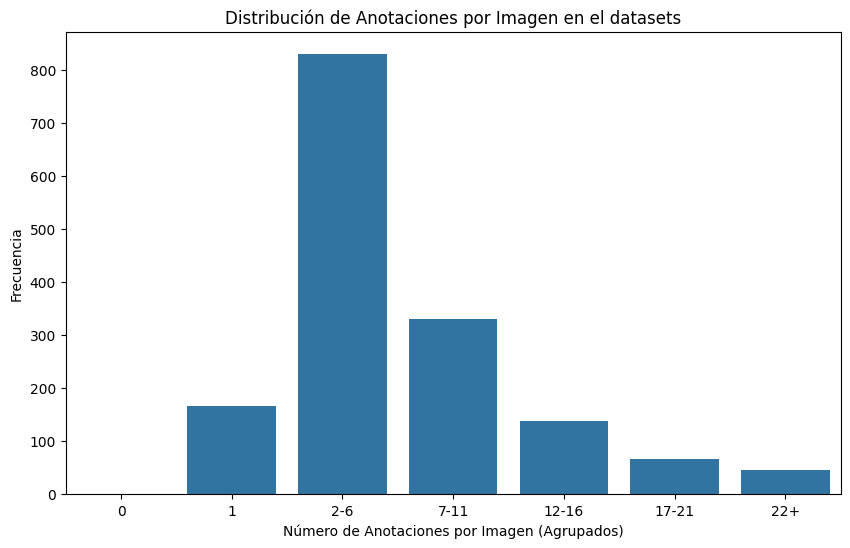

In [54]:
annotations_per_image = df_annotations.groupby('image_id').size()

bins = [0, 1, 2, 7, 12, 17, 22, float('inf')]  # Se agrega un bin adicional para 22+
labels = ['0', '1', '2-6', '7-11', '12-16', '17-21', '22+']

# Cortar los datos en los bins personalizados
annotations_per_image_binned = pd.cut(annotations_per_image, bins=bins, labels=labels, right=False)
# Contar la frecuencia de cada grupo
count_per_bin = annotations_per_image_binned.value_counts().sort_index()

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=count_per_bin.index, y=count_per_bin.values)

# Añadir títulos y etiquetas
plt.title(f'Distribución de Anotaciones por Imagen en el datasets')
plt.xlabel('Número de Anotaciones por Imagen (Agrupados)')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()



##### Frecuencia de Objetos por Clase en Cada Imagen

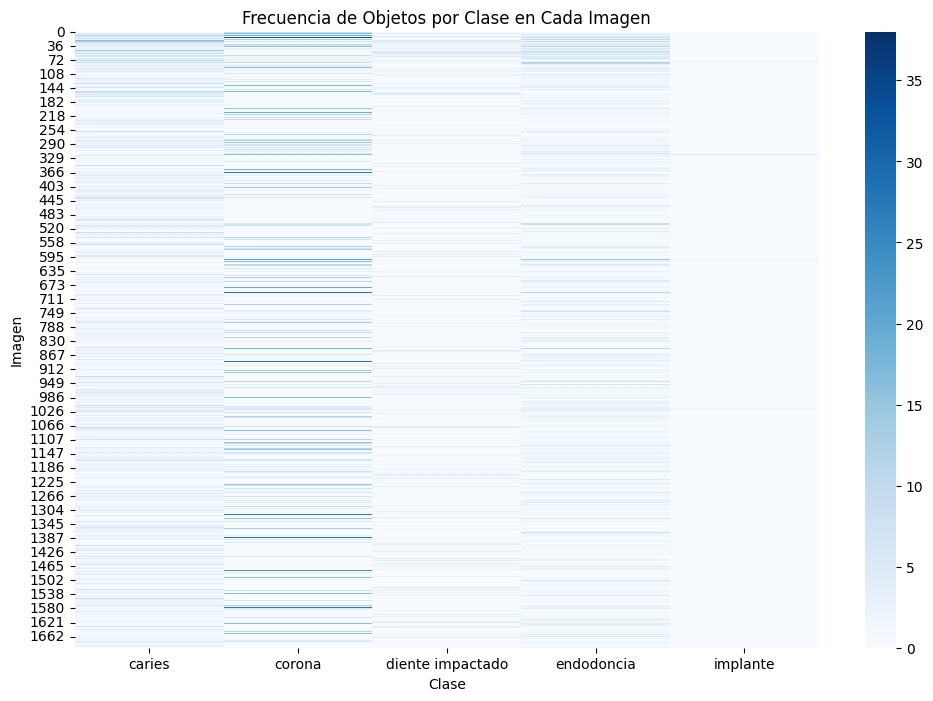

In [55]:
# Crear un DataFrame que asocie imágenes con clases a partir de las anotaciones
class_per_image = pd.DataFrame({
    'image_id': df_annotations['image_id'],
    'class': df_annotations['category_name']
})

# Contar la cantidad de objetos de cada clase por imagen
class_distribution = class_per_image.groupby(['image_id', 'class']).size().unstack(fill_value=0)

# Visualización: Mapa de calor de la frecuencia de objetos por clase en cada imagen
plt.figure(figsize=(12, 8))
sns.heatmap(class_distribution, cmap='Blues', cbar=True)
plt.title('Frecuencia de Objetos por Clase en Cada Imagen')
plt.xlabel('Clase')
plt.ylabel('Imagen')
plt.show()

##### Tamaño Promedio de Bounding Boxes por Clase

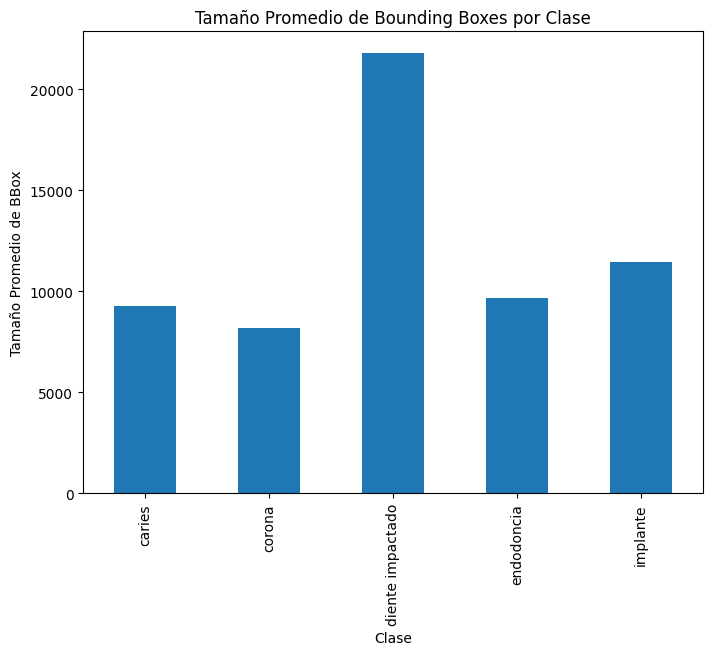

In [56]:
# Tamaño Promedio de los Bounding Boxes por Clase
# variabilidad de los tamaños de los objetos que el modelo necesita detectar.
df_annotations['bbox_area'] = df_annotations['bbox'].apply(lambda x: x[2] * x[3])
bbox_avg_per_class = df_annotations.groupby('category_name')['bbox_area'].mean()

plt.figure(figsize=(8, 6))
bbox_avg_per_class.plot(kind='bar')
plt.title('Tamaño Promedio de Bounding Boxes por Clase')
plt.xlabel('Clase')
plt.ylabel('Tamaño Promedio de BBox')
plt.show()

##### Distribución de Resoluciones de las Imágenes

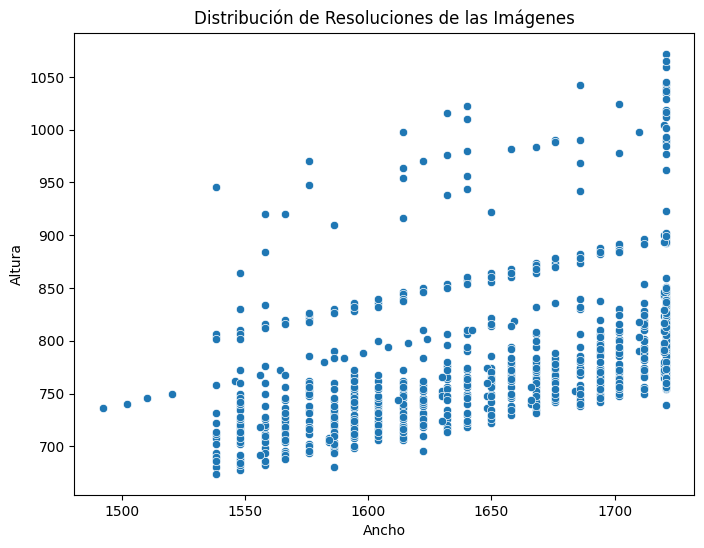

In [57]:
# 4. Distribución de Resoluciones de las Imágenes
image_resolutions = df_images[['height', 'width']].drop_duplicates()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='width', y='height', data=image_resolutions)
plt.title('Distribución de Resoluciones de las Imágenes')
plt.xlabel('Ancho')
plt.ylabel('Altura')
plt.show()

##### Distribución Geográfica de las Anotaciones por Clase

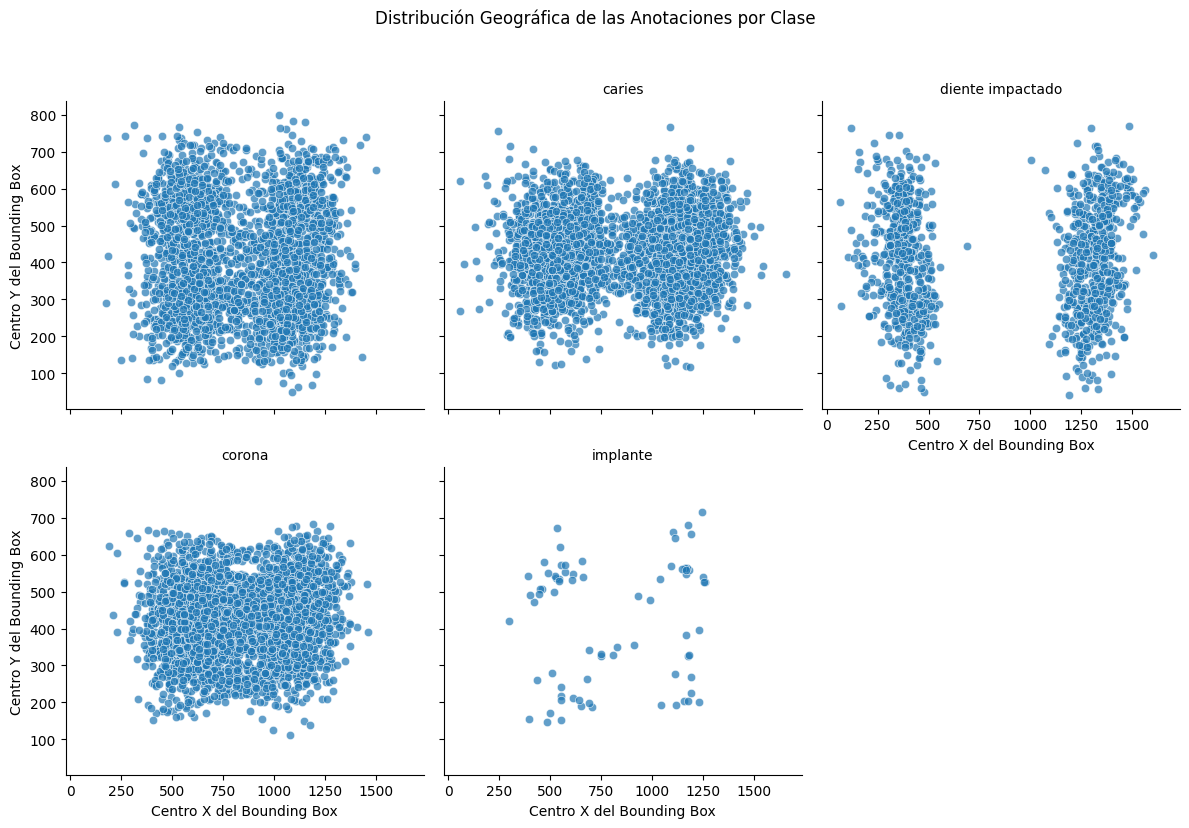

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Añadir las columnas del centro de los bounding boxes
df_annotations['x_center'] = df_annotations['bbox'].apply(lambda x: x[0] + x[2] / 2)
df_annotations['y_center'] = df_annotations['bbox'].apply(lambda x: x[1] + x[3] / 2)

# Crear un FacetGrid para visualizar la distribución por clases
g = sns.FacetGrid(df_annotations, col='category_name', col_wrap=3, height=4)
g.map(sns.scatterplot, 'x_center', 'y_center', alpha=0.7)

# Ajustes adicionales para los gráficos
g.set_titles('{col_name}')
g.set_axis_labels('Centro X del Bounding Box', 'Centro Y del Bounding Box')
g.fig.suptitle('Distribución Geográfica de las Anotaciones por Clase', y=1.03)

plt.tight_layout()
plt.show()


##### Relación Ancho-Altura (Aspect Ratio) de los Bounding Boxes por Clase



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



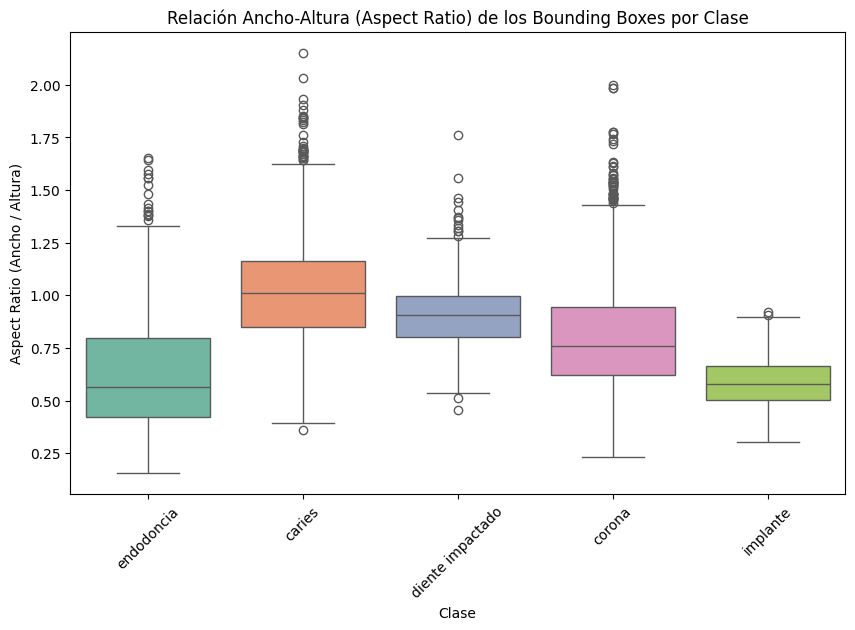

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular el Aspect Ratio (Ancho / Altura)
df_annotations['aspect_ratio'] = df_annotations['bbox'].apply(lambda x: x[2] / x[3])

# Crear un gráfico de distribución del aspect ratio por clase
plt.figure(figsize=(10, 6))
sns.boxplot(x='category_name', y='aspect_ratio', data=df_annotations, palette='Set2')
plt.title('Relación Ancho-Altura (Aspect Ratio) de los Bounding Boxes por Clase')
plt.xlabel('Clase')
plt.ylabel('Aspect Ratio (Ancho / Altura)')
plt.xticks(rotation=45)
plt.show()


----
## CONCLUSIONES


>NOTA: Inicialmente trabajamos con un dataset que presentaba etiquetas incorrectas, lo que resultó en un bajo rendimiento de nuestros modelos. Posteriormente, logramos encontrar una versión mejorada del mismo dataset, con etiquetas correctas y enfocada en el mismo dominio específico. En este documento, analizamos esta nueva versión, mientras que en la presentación se discute en detalle el problema original de etiquetado y su impacto en los resultados.


### Comparación de datasets:
- Dataset Original (DENTEX):

    - Enfocado en 4 categorías: caries, caries profundas, lesiones periapicales y dientes impactados.
    - Incluía imágenes adicionales para detección de cuadrantes y enumeración de dientes.
    - Total de imágenes: 754

- Nuevo Dataset:

    - Total de imágenes: 805
    - 5 categorías: corona, caries, endodoncia, diente impactado, implante

- Principales diferencias:

    -  Categorías:
        - El nuevo dataset incluye "corona" e "implante", que no estaban en el dataset original.
        - Usa "endodoncia" en lugar de "lesiones periapicales".
    
    - Distribución de clases:

        - El nuevo dataset muestra un desbalance menos pronunciado entre las clases principales.
        - "Corona" y "caries" son las categorías dominantes, seguidas de cerca por "endodoncia".
        - "Implante" es una categoría muy minoritaria con solo 34 anotaciones.

- Análisis del nuevo dataset:

    - Distribución de Anotaciones por Imagen
        - La mayoría contiene entre 2 y 6 anotaciones.
        - Número considerable con 7-11 y 12-16 anotaciones.
        - Pocas imágenes con >22 anotaciones o solo 1 anotación.


    - Tamaño promedio de bounding boxes:

        - Los dientes impactados tienen los bounding boxes más grandes en promedio.
        - Implantes y endodoncias tienen tamaños similares, ligeramente mayores que coronas y caries.

    - Distribución geográfica de anotaciones:

        - Cada clase muestra patrones de distribución distintos en las imágenes.
        - Las coronas y caries están más dispersas por toda la imagen.
        - Los dientes impactados tienden a concentrarse en ciertas áreas.
        - Los implantes son escasos y aparecen en ubicaciones específicas.
    
    - Relación ancho-altura de bounding boxes:

        - Las caries muestran la mayor variabilidad en su relación de aspecto.
        - Los implantes tienen la relación de aspecto más consistente y cercana a 1.
        - Endodoncias tienden a tener una relación de aspecto más baja (más altos que anchos).

Conclusiones:
- El nuevo dataset ofrece una representación más completa de diferentes condiciones dentales, incluyendo tratamientos (coronas, implantes).
- El desbalance de clases, aunque menos pronunciado que en el dataset original, aún requiere atención, especialmente para la clase "implante".
- Las técnicas de data augmentation aplicadas probablemente mejoraron la robustez del dataset, pero sería beneficioso analizar su impacto específico en cada clase.
